# Predicting house sale prices #

The housing data used for this project is from the city of Ames, Iowa, United States. More information about the data can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

**The process pipeline:**

- tranform_features
- select_features
- train_and_test
- rmse_values


In [821]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

housing = pd.read_csv('AmesHousing.tsv', sep='\t')

In [822]:
#Function to fit, train, predict and test our model and return rmse values

def train_and_test(df,features):
    train = df.loc[:1460]
    test = df.loc[1460:]
    target = 'SalePrice'
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predict_train = lr.predict(train[features])
    predict_test = lr.predict(test[features])
    mse_train = mean_squared_error(train[target],predict_train)
    mse_test = mean_squared_error(test[target], predict_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    avg_rmse = (rmse_train+rmse_test)/2
    r2_1 = r2_score(train['SalePrice'],predict_train)
    r2_2 = r2_score(test['SalePrice'],predict_test)
    avg_r2 = (r2_1 + r2_2)/2
    return avg_rmse,avg_r2
    

# Transforming and Cleaning Data#

- For numerical columns, we fill missing or NAN columns with column mean if less than 5% of values are missing. 
- For Text columns, if column is categorical with not too many missing values, we replace it with text. Otherwise we drop it.

In [823]:
#Calculating % of mising values in numerical columns and filling them accordingly

def null_values(col,name):
    percentage = ((col.isnull().sum())/len(col)) * 100
    return percentage


num_houses = housing.select_dtypes(include = ['int64','float64']).copy()

for co in num_houses.columns:
    per = null_values(num_houses[co],co)
    if per < 5:
        num_houses[co].fillna(num_houses[co].mean(), inplace=True)
    

In [824]:
#Further filling and Dropping columns 

data = num_houses
ob = housing.copy()
ob = ob.select_dtypes(include = 'object')
ob.drop(columns = 'Alley', inplace= True)
ob.loc[:,'Pool QC'].fillna('No Pool', inplace=True)
ob.loc[:,'Fence'].fillna('No Fence', inplace = True)
ob.loc[:,'Mas Vnr Type'].fillna('No Vnr',inplace = True)
ob.drop(columns ='Misc Feature', inplace = True)
data.drop(columns ='Lot Frontage', inplace = True)
data.drop(columns ='Garage Yr Blt', inplace = True)
ob.loc[:,'Fireplace Qu'].fillna('No Fireplace', inplace = True)

In [825]:
# Concat text and numerical columns
data = pd.concat([ob,data],axis=1)
data['Yr to Remodel'] = data['Year Remod/Add'] - data['Year Built']
text_cols = list(data.select_dtypes(include = 'object').columns)

### Normalizing Data ###

We normalize num columns except identity or label columns and our target column to get a meaningful relationship between the two that can be interpreted by correlations.

**Formula:**
column = (column - column_mean)/(column_max - column_min)

In [826]:
num_cols = list(data.select_dtypes(include = ['int64','float64']).columns)
num_cols.remove('SalePrice')
num_cols.remove('Order')
num_cols.remove('PID')

In [827]:
data[num_cols] = (data[num_cols] - data[num_cols].mean()) / (data[num_cols].max() -data[num_cols].min())

In [828]:
#For reusing the column list and convenience, we append it back
num_cols.append('SalePrice')

# Mapping Correlations ##

Correlations between numerical feature columns with our target 'SalePrice' column gives us enough information to start selecting our features. The stronger the positive correlation, the closer the value is to 1.

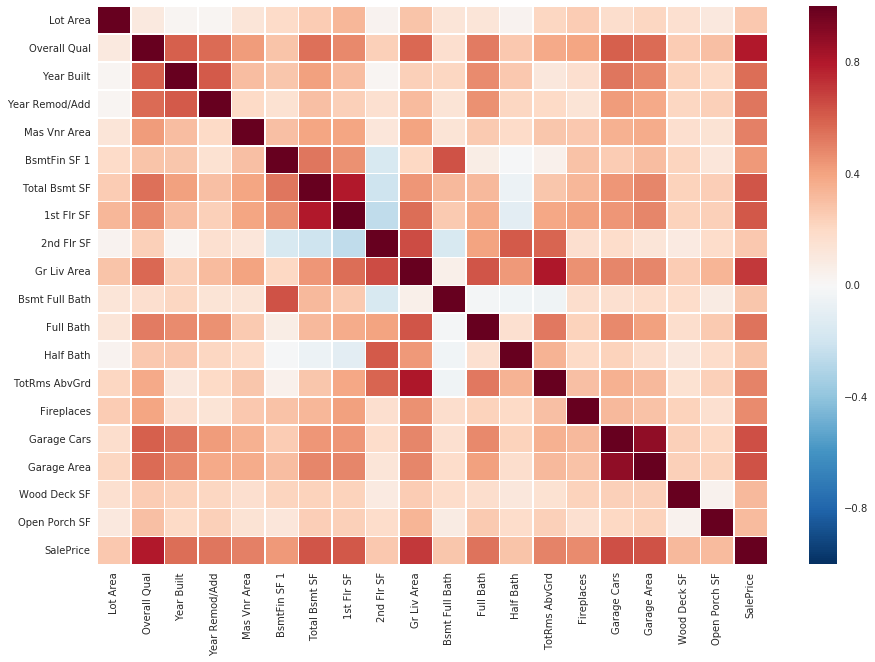

In [829]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

correlations = data[num_cols].corr()
strong_corrs = correlations[correlations['SalePrice']>0.2].copy()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(strong_corrs[strong_corrs.index], linewidths=.5, ax=ax)

From the above heatmap, Overall quality and Gr Liv Area seem to have the highest correlation with SalePrice. We will set these as out features and add more features to get optimal RMSE values through trial and error.

In [830]:
feat = list(strong_corrs.index)
feat.remove('SalePrice')
rmse,r2_nocorr = train_and_test(data,feat)
print('RMSE before converting categorical columns:',rmse)

RMSE before converting categorical columns: 34745.04187725837


# Dealing with Categorical columns #

Categorical values are text values columns that have repeating values. Through trial and error, we select the below values to get the lowest RMSE values.

In [831]:
#get dummies from the following categorical values

text_cols = ['Bldg Type','Garage Type','Neighborhood','Utilities','Lot Config','Foundation','Bsmt Qual','Bsmt Cond','BsmtFin Type 1',
            'Heating QC','Central Air','Kitchen Qual','Garage Qual','Fence','MS Zoning']
dummies = pd.DataFrame()

dummies = pd.get_dummies(data[text_cols])
data = pd.concat([data,dummies], axis=1)
for col in text_cols:
    
    del data[col]

In [832]:
#extract the new dummy column index
cat_cols = list(data.select_dtypes(include='uint8').columns)
for c in strong_corrs.index:
    cat_cols.append(c)

In [833]:
#Setting an arbitrary correlation threshols. Experiment to get optimal RMSE values
overall_corr = data[cat_cols].corr()
good_corr = list(overall_corr[overall_corr['SalePrice'] > 0.2].index)

In [834]:
#calling out train and test function for model fitting and predictions
feat_2 = good_corr
feat_2.remove('SalePrice')
rmse_2,r2_withcorr = train_and_test(data,feat_2)

In [836]:
print('RMSE after converting categorical columns:',rmse_2)


RMSE after converting categorical columns: 30516.601151128627


# Checking co-efficient of determination R2 #
R2 score evaluates the performance of a machine learning model. The function is accessed from the scikitlearn library.

In [837]:
print('R2 score with categorical columns',r2_withcorr)
print('R2 score without categorical columns',r2_nocorr)

R2 score with categorical columns 0.8497269943677487
R2 score without categorical columns 0.8067357707423013


With categorical values converted to numerical columns, the R2 score is 0.85 which mean that this model predicts variations 85% of the time which is adequate.